Stability criterion = 0.25
Source frequency = 100.0 Hz


<IPython.core.display.Javascript object>


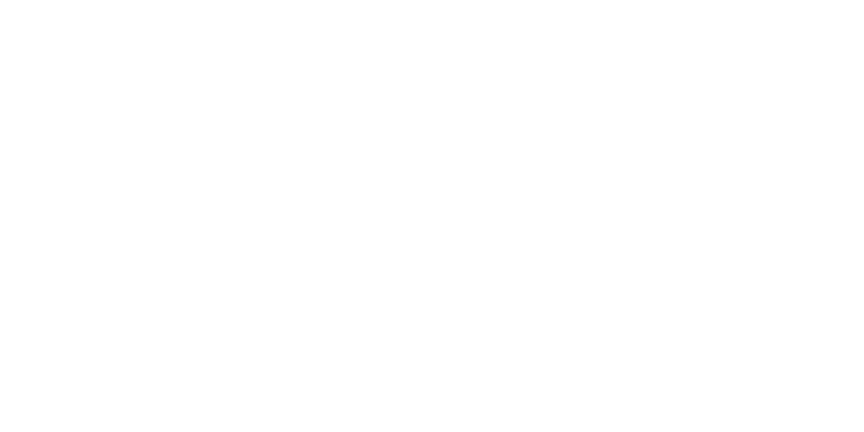

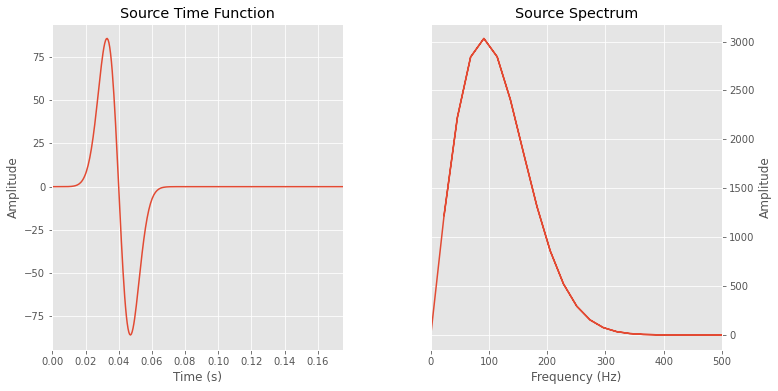

In [74]:
import numpy as np
import matplotlib
matplotlib.use("nbagg")
import matplotlib.pyplot as plt

# Sub-plot Configuration
# ----------------------
from matplotlib import gridspec 
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Ignore Warning Messages
# -----------------------
import warnings
warnings.filterwarnings("ignore")

# Parameter Configuration 
# -----------------------

nx   = 100           # number of grid points in x-direction
ny   = nx            # number of grid points in y-direction
nz   = nx            # number of grid points in z-direction
# Note that for a regular 3D grid dz = dy = dx
dx   = 0.5           # grid point distance in x-direction
dy   = dx            # grid point distance in y-direction
dz   = dx            # grid point distance in z-direction
c0   = 250.          # wave velocity in medium (m/s)
isx  = 50            # source location in grid in x-direction
isy  = isx           # source location in grid in y-direction
isz  = isx           # source location in grid in z-direction
irx  = 57            # receiver location in grid in x-direction
iry  = irx           # receiver location in grid in y-direction
irz  = 10           # receiver location in grid in z-direction
nt   = 351           # maximum number of time steps
dt   = 0.0005        # time step

# CFL Stability Criterion
# -----------------------
eps  = c0 * dt / dx  # epsilon value

print('Stability criterion =', eps)

# Plot Source Time Function 
# -------------------------

f0   = 100. # dominant frequency of the source (Hz)
t0   = 4. / f0 # source time shift

print('Source frequency =', f0, 'Hz')

# Source time function (Gaussian)
# -------------------------------
src  = np.zeros(nt + 1)
time = np.linspace(0 * dt, nt * dt, nt)
# 1st derivative of a Gaussian
src  = -2. * (time - t0) * (f0 ** 2) * (np.exp(-1.0 * (f0 ** 2) * (time - t0) ** 2))

# Plot Source Time Function
# -------------------------
plt.ion()
fig1  = plt.figure(figsize=(12, 6))
gs1   = gridspec.GridSpec(1, 2, width_ratios=[1, 1], hspace=0.3, wspace=0.3)

# Plot Source Time Function
# -------------------------
ax1  = plt.subplot(gs1[0])
ax1.plot(time, src) # plot source time function
ax1.set_title('Source Time Function')
ax1.set_xlim(time[0], time[-1])
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Amplitude')

# Plot Source Spectrum
# --------------------
ax2  = plt.subplot(gs1[1])
spec = np.fft.fft(src) # amplitude of the source in frequency domain
freq = np.fft.fftfreq(spec.size, d = dt / 4.) # change time domain to frequency domain of the source
ax2.plot(np.abs(freq), np.abs(spec)) # plot frequency and spectrum of the source
ax2.set_xlim(0, 500) # only display frequency from 0 to 500 Hz
ax2.set_title('Source Spectrum')
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('Amplitude')

ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")

plt.show()


<IPython.core.display.Javascript object>


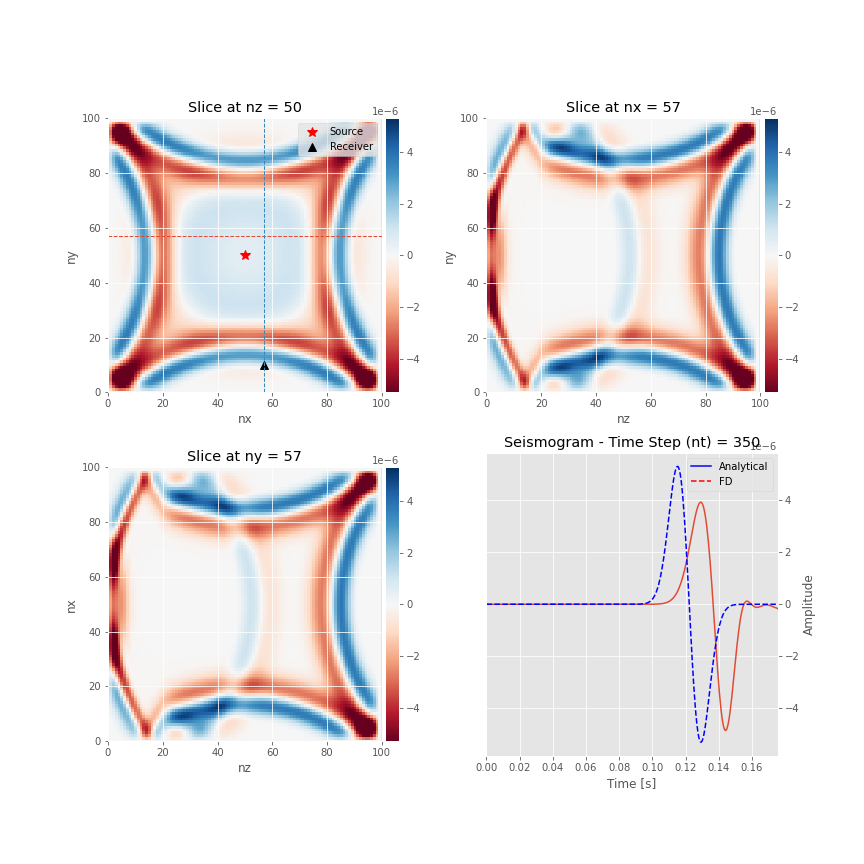

3 - point operator


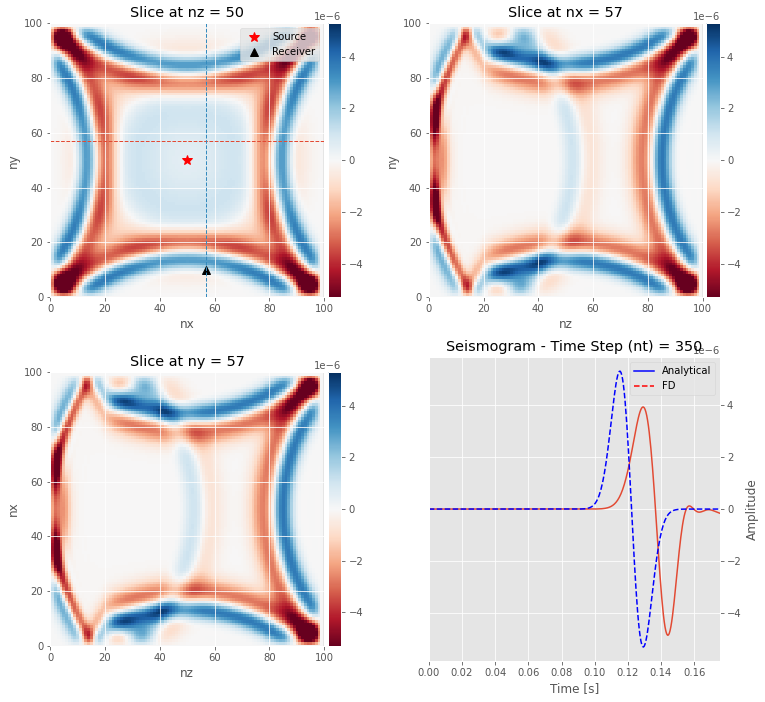

In [75]:
# Initialize Empty Pressure
# -------------------------
p    = np.zeros((nx, ny, nz)) # p at time n (now)
pold = np.zeros((nx, ny, nz)) # p at time n-1 (past)
pnew = np.zeros((nx, ny, nz)) # p at time n+1 (present)
d2px = np.zeros((nx, ny, nz)) # 2nd space derivative of p in x-direction
d2py = np.zeros((nx, ny, nz)) # 2nd space derivative of p in y-direction
d2pz = np.zeros((nx, ny, nz)) # 2nd space derivative of p in z-direction

# Initialize Velocity Model (assume homogeneous model)
# ----------------------------------------------------
c    = np.zeros((nx, ny, nz))
c    = c + c0 # initialize wave velocity in model
c[:,:,1:20] *= 0.6


# Initialize Grid
# ---------------
x    = np.arange(nx)
x    = x * dx                 # coordinate in x-direction
y    = np.arange(ny)
y    = y * dy                 # coordinate in y-direction
z    = np.arange(nz)
z    = z * dz                 # coordinate in z-direction

# Initialize Empty Seismogram
# ---------------------------
seis = np.zeros(nt) 

# Analytical Solution 
# -------------------
G    = time * 0.0
r    = np.sqrt((x[isx] - x[irx]) ** 2 + (y[isy] - y[iry]) ** 2 + (z[isz] - z[irz]) ** 2)
t_ar = time[0] + r / c0
i_ar = int(t_ar / dt)
G[i_ar] = 1.0 / (4 * np.pi * c0 ** 2 * r) # Calculate Green's function
Gc   = np.convolve(G, src)
Gc   = Gc[0:nt]
lim  = Gc.max() # get limit value from maximum amplitude of analytical solution

# Plot Position Configuration
# ---------------------------
plt.ion()
fig2 = plt.figure(figsize=(12, 12))
gs2  = gridspec.GridSpec(2,2,width_ratios=[1,1],height_ratios=[1,1],hspace=0.15, wspace=0.3)

# Plot 3D Wave Propagation

# 2D Slice at nz
ax3  = plt.subplot(gs2[0])
leg1,= ax3.plot(isx, isz, 'r*', markersize=11) # plot source location
leg2,= ax3.plot(irx, irz, 'k^', markersize=8) # plot receiver location
slc1,= plt.plot(np.array([0,nx]),np.array([irx,irx]), linewidth=1, linestyle='--') # plot 2D slice at nx
slc2,= plt.plot(np.array([irx,irx]),np.array([0,ny]), linewidth=1, linestyle='--') # plot 2D slice at ny
im3  = ax3.imshow(p[:,:,isz],vmin=-lim, vmax=+lim, interpolation='nearest', cmap=plt.cm.RdBu)
div3 = make_axes_locatable(ax3)
cax3 = div3.append_axes("right", size="5%", pad=0.05) # size & position of colorbar
fig2.colorbar(im3, cax=cax3) # plot colorbar
ax3.set_title('Slice at nz = %d' % isz)
ax3.set_xlim(0, nz)
ax3.set_ylim(0, ny)
ax3.set_xlabel('nx')
ax3.set_ylabel('ny')
ax3.legend((leg1, leg2), ('Source', 'Receiver'), loc='upper right', fontsize=10, numpoints=1)

# 2D Slice at nx
ax4  = plt.subplot(gs2[1])
im4  = ax4.imshow(p[irx,:,:],vmin=-lim, vmax=+lim, interpolation="nearest", cmap=plt.cm.RdBu)
div4 = make_axes_locatable(ax4)
cax4 = div4.append_axes("right", size="5%", pad=0.05) # size & position of colorbar
fig2.colorbar(im4, cax=cax4) # plot colorbar
ax4.set_title('Slice at nx = %d' % irx)
ax4.set_xlim(0, nz)
ax4.set_ylim(0, ny)
ax4.set_xlabel('nz')
ax4.set_ylabel('ny')

# 2D Slice at ny
ax5  = plt.subplot(gs2[2])
im5  = ax5.imshow(p[:,irx,:],vmin=-lim, vmax=+lim, interpolation="nearest", cmap=plt.cm.RdBu)
div5 = make_axes_locatable(ax5)
cax5 = div5.append_axes("right", size="5%", pad=0.05) # size & position of colorbar
fig2.colorbar(im5, cax=cax5) # plot colorbar
ax5.set_title('Slice at ny = %d' % irx)
ax5.set_xlim(0, nx)
ax5.set_ylim(0, nz)
ax5.set_xlabel('nz')
ax5.set_ylabel('nx')

# Plot Seismogram 
ax6  = plt.subplot(gs2[3])
up61,= ax6.plot(time, seis) # update seismogram each time step
up62,= ax6.plot([0], [0], 'r|', markersize=15) # update time step position
#ax6.set_ylim(-lim, lim)
ax6.set_xlim(time[0], time[-1])
ax6.set_title('Seismogram - Time Step (nt) = 0')
ax6.set_xlabel('Time [s]')
ax6.set_ylabel('Amplitude')
leg3,= ax6.plot(0,0,'b-',markersize=1)
leg4,= ax6.plot(0,0,'r--',markersize=1)
ax6.legend((leg3, leg4), ('Analytical', 'FD'), loc='upper right', fontsize=10, numpoints=1)

ax6.yaxis.tick_right()
ax6.yaxis.set_label_position("right")

plt.plot(time,Gc,'b--')
plt.show()


# Point Operator (choose 3 or 5 point operator)
op   = 3 
print(op, '- point operator')

# Calculate Partial Derivatives
for it in range(nt):
    if op == 3: # use 3 point operator FD scheme
        for i in range(1, nz - 1):
                d2pz[:, :, i] = (p[:, :, i + 1] - 2 * p[:, :, i] + p[:, :, i - 1]) / dz ** 2
        for j in range(1, ny - 1):
                d2py[:, j, :] = (p[:, j + 1, :] - 2 * p[:, j, :] + p[:, j - 1, :]) / dy ** 2
        for k in range(1, nx - 1):
                d2px[k, :, :] = (p[k + 1, :, :] - 2 * p[k, :, :] + p[k - 1, :, :]) / dx ** 2
    
    if op == 5: # use 5 point operator FD scheme
        for i in range(2, nz - 2):
                d2pz[:, :, i] = (-1./12 * p[:,:,i+2] + 4./3  * p[:,:,i+1] - 5./2 * p[:,:,i] \
                                + 4./3  * p[:,:,i-1] - 1./12 * p[:,:,i-2]) / dz ** 2
        for j in range(2, ny - 2):
                d2py[:, j, :] = (-1./12 * p[:,j+2,:] + 4./3  * p[:,j+1,:] - 5./2 * p[:,j,:] \
                                + 4./3  * p[:,j-1,:] - 1./12 * p[:,j-2,:]) / dy ** 2
        for k in range(2, nx - 2):
                d2px[k, :, :] = (-1./12 * p[k+2,:,:] + 4./3  * p[k+1,:,:] - 5./2 * p[k,:,:] \
                                + 4./3  * p[k-1,:,:] - 1./12 * p[k-2,:,:]) / dx ** 2


    # Time Extrapolation
    # ------------------
    pnew = 2 * p - pold + (c ** 2) * (dt ** 2) * (d2px + d2py + d2pz)
    
    # Add Source Term at isx, isy and isz
    # -----------------------------------
    pnew[isx, isy, isz] = pnew[isx, isy, isz] + src[it] / (dx * dy * dz) * (dt ** 2)
    
    # Remap Time Levels
    # -----------------
    pold, p = p, pnew
    
    # Output Seismogram
    # -----------------
    seis[it] = p[irx, iry, irz]
    
    # Update data for Wave Propagation Plot
    # -------------------------------------
    idisp = 5 # display frequency
    if (it % idisp) == 0:
        ax3.imshow(p[:, :, isx],vmin=-lim, vmax=+lim, interpolation="nearest", cmap=plt.cm.RdBu)
        ax4.imshow(p[irx, :, :],vmin=-lim, vmax=+lim, interpolation="nearest", cmap=plt.cm.RdBu)
        ax5.imshow(p[:, irx, :],vmin=-lim, vmax=+lim, interpolation="nearest", cmap=plt.cm.RdBu)
        ax6.set_title('Seismogram - Time Step (nt) = %d' % it)
        up61.set_ydata(seis)
        up62.set_data(time[it], seis[it])
        fig2.canvas.draw()



<IPython.core.display.Javascript object>


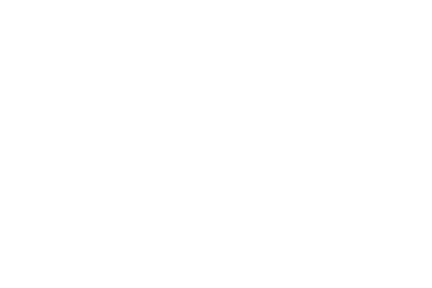

150.0


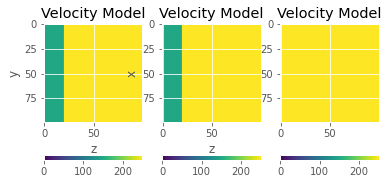

In [81]:
plt.subplot(131)
# The velocity model is influenced by the Earth model above
plt.title('Velocity Model')
plt.imshow(c[50,:,:],vmin=0,vmax=250)
plt.colorbar(orientation='horizontal')
plt.xlabel('z')
plt.ylabel('y')

plt.subplot(132)
# The velocity model is influenced by the Earth model above
plt.title('Velocity Model')
plt.imshow(c[:,90,:],vmin=0,vmax=250)
plt.colorbar(orientation='horizontal')
plt.xlabel('z')
plt.ylabel('x')

plt.subplot(133)
# The velocity model is influenced by the Earth model above
plt.title('Velocity Model')
plt.imshow(c[:,:,25],vmin=0,vmax=250)
plt.colorbar(orientation='horizontal')

print (c[2,80,19])

[ 8.33333333e-02 -6.66666667e-01 -2.37904934e-16  6.66666667e-01
 -8.33333333e-02]


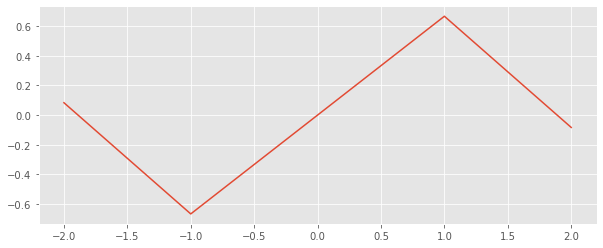

In [2]:
import math
import numpy as np


def central_difference_coefficients(nop, n):

# param nop: The number of points for the stencil. Must be an odd number.
# param n: The derivative order. Must be a positive number.

    m = np.zeros((nop, nop))
    for i in range(nop):
        for j in range(nop):
            dx = j - nop // 2
            m[i, j] = dx ** i
    
    s = np.zeros(nop)
    s[n] = math.factorial(n)
    
    oper = np.linalg.solve(m, s)
    return oper



# ## Plot Taylor operators

# Some necessary initialization
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Give length of operator (odd)
nop =5
# Give order of derivative (0 - interpolation, 1 - first derivative, 2 - second derivative)
n = 1

# Get operator 
oper = central_difference_coefficients(nop, n)

# Initialize location of operator
x = np.linspace(-(nop - 1) / 2, (nop - 1) / 2, nop)

# Simple plot with operator
print (oper)
plt.figure(figsize=(10, 4))
plt.plot(x, oper)
plt.show()



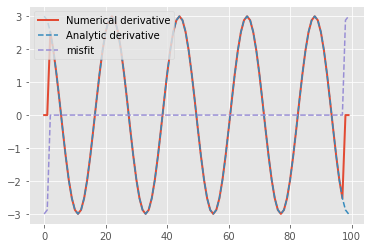

In [5]:
nx = 100        # Number of points in x
x = np.linspace(0, 3 * np.pi, nx)

# We initialite a function f as a sin curve with wavenumber k
k = 3
f = np.sin(k * x)

# The analytical derivative is given by
dfa = k * np.cos(k * x)

# We need to know the grid spacing dx 
dx = x[2] - x[1]

# Now let's get the finite difference operator with paramters
nop = 5 # Length of operator
n = 1   #  1 st derivative
oper = central_difference_coefficients(nop, n)

# Calculate the derivative of f(x) by applying the finite-difference operator
df = np.zeros(nx)
# Loop over the central points where we calculate the derivatives
for i in range(nop // 2, nx - nop // 2):  # Avoid the boundaries
    # Loop over operator
    for j in range(0, nop):  
       df[i] = df[i] + oper[j] * f[i - (nop - 1) // 2 + j]
           
# Scale by dx.
df /= dx ** n

plt.plot(df, label="Numerical derivative", lw=2)
plt.plot(dfa, ls="--",label="Analytic derivative")
plt.plot(df-dfa, ls = '--',label='misfit')
plt.legend()
plt.show()